In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
d_parser = lambda x:pd.to_datetime(x, errors='coerce')

In [ ]:
df = pd.read_csv('breach_report.csv', encoding= 'latin1', 
                 dtype={'Type of Breach':'string'},
                 parse_dates=['Breach Submission Date'], date_parser=d_parser)

In [ ]:
df.head(5)

,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description
0,Brooke Army Medical Center,TX,Healthcare Provider,1000.0,2009-10-21,Theft,Paper/Films,No,A binder containing the protected health infor...
1,"Mid America Kidney Stone Association, LLC",MO,Healthcare Provider,1000.0,2009-10-28,Theft,Network Server,No,Five desktop computers containing unencrypted ...
2,Alaska Department of Health and Social Services,AK,Healthcare Provider,501.0,2009-10-30,Theft,"Other, Other Portable Electronic Device",No,\N
3,Health Services for Children with Special Need...,DC,Health Plan,3800.0,2009-11-17,Loss,Laptop,No,A laptop was lost by an employee while in tran...
4,"Mark D. Lurie, MD",CA,Healthcare Provider,5166.0,2009-11-20,Theft,Desktop Computer,No,A shared Computer that was used for backup was...


In [ ]:
df.dtypes

Name of Covered Entity                      object
State                                       object
Covered Entity Type                         object
Individuals Affected                       float64
Breach Submission Date              datetime64[ns]
Type of Breach                              string
Location of Breached Information            object
Business Associate Present                  object
Web Description                             object
dtype: object

In [ ]:
df.shape

(1700, 9)

In [ ]:
df1 = df.loc[(df['Breach Submission Date'] <= '2013-09-30')]

In [ ]:
#df1.groupby(df1['Breach Submission Date'])[['Breach Submission Date']].sum()

In [ ]:
df1.isna().sum(axis = 0)

Name of Covered Entity               0
State                                6
Covered Entity Type                 23
Individuals Affected                14
Breach Submission Date               0
Type of Breach                      10
Location of Breached Information     7
Business Associate Present           0
Web Description                     11
dtype: int64

In [ ]:
round(df1.isna().sum() * 100/len(df),2)

Name of Covered Entity              0.00
State                               0.35
Covered Entity Type                 1.35
Individuals Affected                0.82
Breach Submission Date              0.00
Type of Breach                      0.59
Location of Breached Information    0.41
Business Associate Present          0.00
Web Description                     0.65
dtype: float64

In [ ]:
df1 = df1.dropna(subset = ['State','Covered Entity Type','Individuals Affected','Type of Breach','Location of Breached Information', 'Web Description'])

In [ ]:
round(df1.isna().sum() * 100/len(df1),2)

Name of Covered Entity              0.0
State                               0.0
Covered Entity Type                 0.0
Individuals Affected                0.0
Breach Submission Date              0.0
Type of Breach                      0.0
Location of Breached Information    0.0
Business Associate Present          0.0
Web Description                     0.0
dtype: float64

In [ ]:
df1.groupby(['Type of Breach']).sum()

,Individuals Affected
Type of Breach,
Hacking/IT Incident,1231391.0
"Hacking/IT Incident, Other",3200.0
"Hacking/IT Incident, Other, Unauthorized Access/Disclosure",4354.0
"Hacking/IT Incident, Theft",27800.0
"Hacking/IT Incident, Theft, Unauthorized Access/Disclosure",13800.0
"Hacking/IT Incident, Unauthorized Access/Disclosure",62487.0
Improper Disposal,620927.0
"Improper Disposal, Loss",3430.0
"Improper Disposal, Loss, Theft",1950.0


In [ ]:
for x in df1['Type of Breach']:
  if 'Hacking/IT Incident' in x:
    df1.loc[df1['Type of Breach'] == x,'Breach Type'] = 'Hacking/IT Incident'
    continue
  if 'Improper Disposal' in x:
    df1.loc[df1['Type of Breach'] == x,'Breach Type'] = 'Improper Disposal'
    continue
  if 'Loss' in x:
    df1.loc[df1['Type of Breach'] == x,'Breach Type'] = 'Loss'
    continue
  if 'Unauthorized Access/Disclosure' in x:
    df1.loc[df1['Type of Breach'] == x,'Breach Type'] = 'Unauthorized Access/Disclosure'
    continue
  if 'Theft' in x:
    df1.loc[df1['Type of Breach'] == x,'Breach Type'] = 'Theft'
    continue
  if 'Unknown' in x or 'Other' in x:
    df1.loc[df1['Type of Breach'] == x,'Breach Type'] = 'Other/Unkown'
    continue

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
df1.head()

,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description,Breach Type
0,Brooke Army Medical Center,TX,Healthcare Provider,1000.0,2009-10-21,Theft,Paper/Films,No,A binder containing the protected health infor...,Theft
1,"Mid America Kidney Stone Association, LLC",MO,Healthcare Provider,1000.0,2009-10-28,Theft,Network Server,No,Five desktop computers containing unencrypted ...,Theft
2,Alaska Department of Health and Social Services,AK,Healthcare Provider,501.0,2009-10-30,Theft,"Other, Other Portable Electronic Device",No,\N,Theft
3,Health Services for Children with Special Need...,DC,Health Plan,3800.0,2009-11-17,Loss,Laptop,No,A laptop was lost by an employee while in tran...,Loss
4,"Mark D. Lurie, MD",CA,Healthcare Provider,5166.0,2009-11-20,Theft,Desktop Computer,No,A shared Computer that was used for backup was...,Theft


In [ ]:
df1.groupby(['Breach Type']).sum()

,Individuals Affected
Breach Type,
Hacking/IT Incident,1343032.0
Improper Disposal,644108.0
Loss,7101794.0
Other/Unkown,2781311.0
Theft,13852804.0
Unauthorized Access/Disclosure,936979.0


In [ ]:
df1['Location of Breached Information'].value_counts()

Paper/Films                                                                                                                         174
Laptop                                                                                                                              166
Other                                                                                                                                85
Desktop Computer                                                                                                                     82
Network Server                                                                                                                       67
Other, Other Portable Electronic Device                                                                                              43
Other Portable Electronic Device                                                                                                     37
Email                                           

In [ ]:
for x in df1['Location of Breached Information']:
  if 'Desktop Computer' in x:
    df1.loc[df1['Location of Breached Information'] == x,'Location'] = 'Desktop Computers'
    continue
  if 'Electronic Medical Record' in x:
    df1.loc[df1['Location of Breached Information'] == x,'Location'] = 'Electronic health records'
    continue
  if 'Email' in x:
    df1.loc[df1['Location of Breached Information'] == x,'Location'] = 'E-mail'
    continue
  if 'Laptop' in x:
    df1.loc[df1['Location of Breached Information'] == x,'Location'] = 'Laptops'
    continue
  if 'Network Server' in x:
    df1.loc[df1['Location of Breached Information'] == x,'Location'] = 'Network Servers'
    continue
  if 'Other' in x:
    df1.loc[df1['Location of Breached Information'] == x,'Location'] = 'Others'
  if 'Paper' in x:
    df1.loc[df1['Location of Breached Information'] == x,'Location'] = 'Paper'
    continue

In [ ]:
df1.groupby(['Location']).sum()

,Individuals Affected
Location,
Desktop Computers,6610269.0
E-mail,333546.0
Electronic health records,2693049.0
Laptops,2693433.0
Network Servers,1878306.0
Others,11320147.0
Paper,1131278.0


In [ ]:
df1['Business Associate Present'].value_counts()

No     596
Yes    166
Name: Business Associate Present, dtype: int64

In [ ]:
df1['Business Associate Present'] = df1['Business Associate Present'].map({'Yes':1, 'No':0})

In [ ]:
df1['Business Associate Present'].value_counts()

0    596
1    166
Name: Business Associate Present, dtype: int64

In [ ]:
df1.groupby(['Location']).sum()

,Individuals Affected,Business Associate Present
Location,,
Desktop Computers,6610269.0,12
E-mail,333546.0,2
Electronic health records,2693049.0,3
Laptops,2693433.0,28
Network Servers,1878306.0,24
Others,11320147.0,51
Paper,1131278.0,46


In [ ]:
for x in df1['Covered Entity Type']:
  if x:
    df1.loc[df1['Covered Entity Type'] == x,'Covered Entities Involved'] = 1
  else:
    df1.loc[df1['Covered Entity Type'] == x,'Covered Entities Involved'] = 0

In [ ]:
df1.groupby(['Breach Type']).sum()

,Individuals Affected,Business Associate Present,Covered Entities Involved
Breach Type,,,
Hacking/IT Incident,1343032.0,13,52.0
Improper Disposal,644108.0,9,35.0
Loss,7101794.0,15,68.0
Other/Unkown,2781311.0,17,59.0
Theft,13852804.0,78,442.0
Unauthorized Access/Disclosure,936979.0,34,106.0


In [ ]:
df1.groupby(['Location']).sum()

,Individuals Affected,Business Associate Present,Covered Entities Involved
Location,,,
Desktop Computers,6610269.0,12,117.0
E-mail,333546.0,2,27.0
Electronic health records,2693049.0,3,25.0
Laptops,2693433.0,28,180.0
Network Servers,1878306.0,24,69.0
Others,11320147.0,51,165.0
Paper,1131278.0,46,179.0


In [ ]:
df1.groupby(['State']).sum()

,Individuals Affected,Business Associate Present,Covered Entities Involved
State,,,
AK,6944.0,2,4.0
AL,986990.0,1,8.0
AR,19383.0,1,7.0
AZ,141116.0,2,19.0
CA,1287835.0,17,82.0
CO,125169.0,2,10.0
CT,202536.0,5,15.0
DC,11705.0,1,5.0
FL,2792774.0,1,50.0


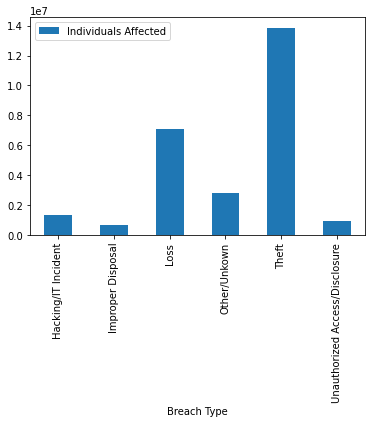

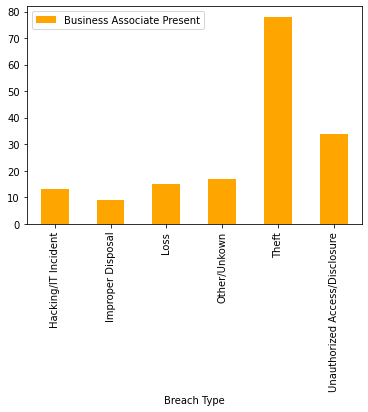

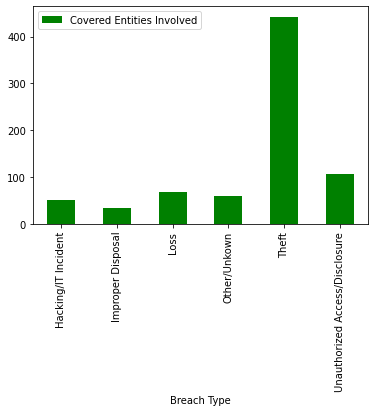

In [ ]:
tob = df1.groupby(['Breach Type']).sum()
tob.plot(kind = 'bar', y='Individuals Affected')
tob.plot(kind = 'bar', y='Business Associate Present', color='orange')
tob.plot(kind = 'bar', y='Covered Entities Involved', color = 'green')

In [ ]:
df2 = df1.groupby(['Breach Type']).sum()
df3 = df2.apply(lambda x:100 * x / float(x.sum()))
df3.head()

,Individuals Affected,Business Associate Present,Covered Entities Involved
Breach Type,,,
Hacking/IT Incident,5.037624,7.831325,6.824147
Improper Disposal,2.416006,5.421687,4.593176
Loss,26.638359,9.036145,8.923885
Other/Unkown,10.432513,10.240964,7.742782
Theft,51.960951,46.987952,58.005249


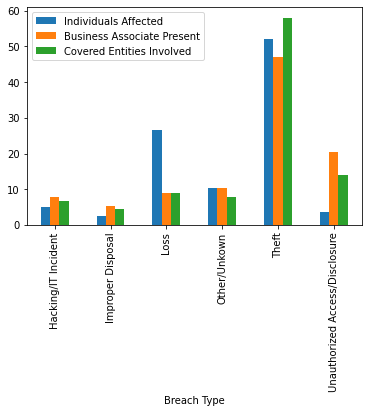

In [ ]:
df3.plot(kind = 'bar')

In [ ]:
df2 = df1.groupby(['Location']).sum()
df4 = df2.apply(lambda x:100 * x / float(x.sum()))
df4.head()

,Individuals Affected,Business Associate Present,Covered Entities Involved
Location,,,
Desktop Computers,24.794681,7.228916,15.354331
E-mail,1.251109,1.204819,3.543307
Electronic health records,10.101449,1.807229,3.280840
Laptops,10.102889,16.867470,23.622047
Network Servers,7.045401,14.457831,9.055118


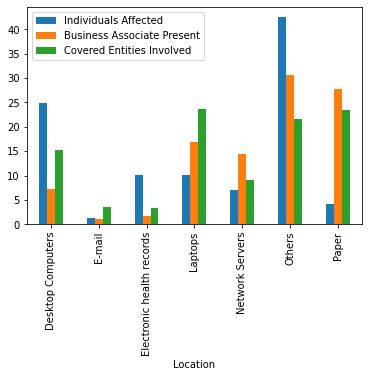

In [ ]:
df4.plot(kind = 'bar')

In [ ]:
df2 = df1.groupby(['State']).sum()
df5 = df2.apply(lambda x:100 * x / float(x.sum()))
df5.nlargest(10, 'Individuals Affected')

,Individuals Affected,Business Associate Present,Covered Entities Involved
State,,,
VA,18.874620,3.614458,1.968504
IL,16.239934,7.228916,4.986877
FL,10.475510,0.602410,6.561680
NY,9.174443,6.024096,6.036745
NJ,6.658763,3.012048,1.049869
CA,4.830584,10.240964,10.761155
PA,4.355416,6.024096,3.674541
TN,4.249482,1.807229,2.755906
AL,3.702134,0.602410,1.049869


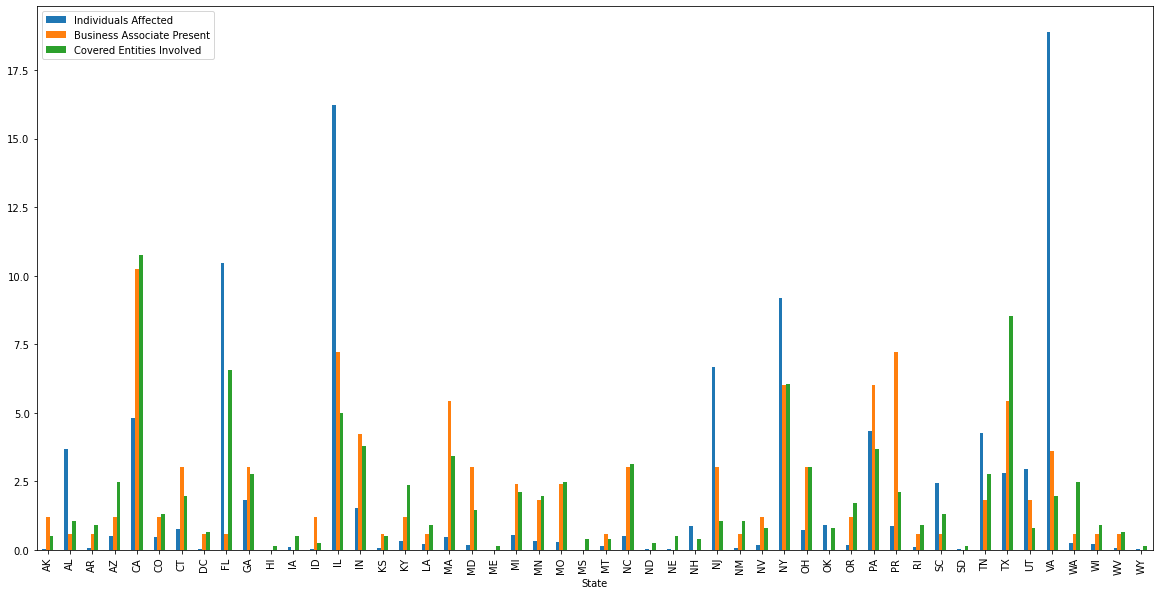

In [ ]:
df5.plot(kind = 'bar', figsize = (20,10))

In [ ]:
df1.groupby(['State','Location']).sum()

Individuals Affected  Business Associate Present  \
State Location                                                              
AK    Desktop Computers                2743.0                           0   
      Laptops                          1700.0                           1   
      Others                           2501.0                           1   
AL    Desktop Computers              966578.0                           0   
      Laptops                          2465.0                           0   
...                                       ...                         ...   
WI    Paper                            2400.0                           0   
WV    Laptops                         12563.0                           0   
      Network Servers                  3655.0                           1   
      Paper                            5325.0                           0   
WY    Desktop Computers               15000.0                           0   

                         Covered Entities Involved  
State Location                                      
AK    Desktop Computers                        1.0  
      Laptops                                  1.0  
      Others                                   2.0  
AL    Desktop Computers                        3.0  
      Laptops                                  1.0  
...                                            ...  
WI    Paper                                    1.0  
WV    Laptops                                  1.0  
      Network Servers                          1.0  
      Paper                                    3.0  
WY    Desktop Computers                        1.0  

[218 rows x 3 columns]

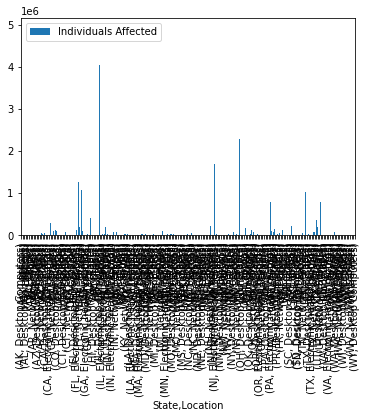

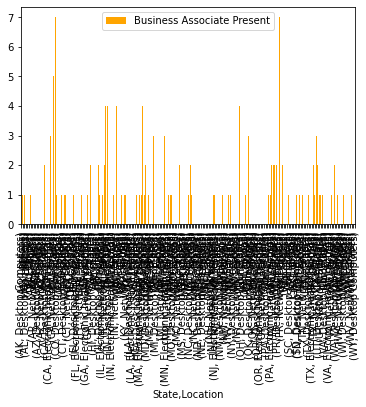

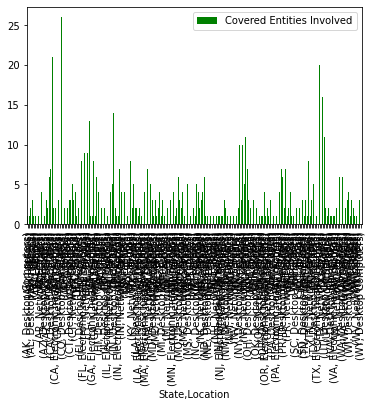

In [ ]:
#Plot only the highest
df2 = df1.groupby(['State','Location']).sum()
df2.plot(kind = 'bar', y='Individuals Affected')
df2.plot(kind = 'bar', y='Business Associate Present', color='orange')
df2.plot(kind = 'bar', y='Covered Entities Involved', color = 'green')

In [ ]:
df2 = df1.groupby(['State','Location']).sum()
df5 = df2.apply(lambda x:100 * x / float(x.sum()))
df5.head()

Individuals Affected  Business Associate Present  \
State Location                                                              
AK    Desktop Computers              0.010289                     0.00000   
      Laptops                        0.006377                     0.60241   
      Others                         0.009381                     0.60241   
AL    Desktop Computers              3.625570                     0.00000   
      Laptops                        0.009246                     0.00000   

                         Covered Entities Involved  
State Location                                      
AK    Desktop Computers                   0.131234  
      Laptops                             0.131234  
      Others                              0.262467  
AL    Desktop Computers                   0.393701  
      Laptops                             0.131234

In [ ]:
df1.groupby(['State','Breach Type']).sum()

Individuals Affected  \
State Breach Type                                            
AK    Theft                                         4201.0   
      Unauthorized Access/Disclosure                2743.0   
AL    Improper Disposal                             1655.0   
      Theft                                       971043.0   
      Unauthorized Access/Disclosure               14292.0   
...                                                    ...   
WI    Unauthorized Access/Disclosure               43549.0   
WV    Loss                                         12563.0   
      Theft                                         2905.0   
      Unauthorized Access/Disclosure                6075.0   
WY    Theft                                        15000.0   

                                      Business Associate Present  \
State Breach Type                                                  
AK    Theft                                                    2   
      Unauthorized Access/Disclosure                           0   
AL    Improper Disposal                                        0   
      Theft                                                    0   
      Unauthorized Access/Disclosure                           1   
...                                                          ...   
WI    Unauthorized Access/Disclosure                           0   
WV    Loss                                                     0   
      Theft                                                    0   
      Unauthorized Access/Disclosure                           1   
WY    Theft                                                    0   

                                      Covered Entities Involved  
State Breach Type                                                
AK    Theft                                                 3.0  
      Unauthorized Access/Disclosure                        1.0  
AL    Improper Disposal                                     1.0  
      Theft                                                 5.0  
      Unauthorized Access/Disclosure                        2.0  
...                                                         ...  
WI    Unauthorized Access/Disclosure                        1.0  
WV    Loss                                                  1.0  
      Theft                                                 1.0  
      Unauthorized Access/Disclosure                        3.0  
WY    Theft                                                 1.0  

[187 rows x 3 columns]

In [ ]:
df2 = df1.groupby(['State','Breach Type']).sum()
df5 = df2.apply(lambda x:100 * x / float(x.sum()))
df5.head()

Individuals Affected  \
State Breach Type                                            
AK    Theft                                       0.015758   
      Unauthorized Access/Disclosure              0.010289   
AL    Improper Disposal                           0.006208   
      Theft                                       3.642318   
      Unauthorized Access/Disclosure              0.053608   

                                      Business Associate Present  \
State Breach Type                                                  
AK    Theft                                             1.204819   
      Unauthorized Access/Disclosure                    0.000000   
AL    Improper Disposal                                 0.000000   
      Theft                                             0.000000   
      Unauthorized Access/Disclosure                    0.602410   

                                      Covered Entities Involved  
State Breach Type                                                
AK    Theft                                            0.393701  
      Unauthorized Access/Disclosure                   0.131234  
AL    Improper Disposal                                0.131234  
      Theft                                            0.656168  
      Unauthorized Access/Disclosure                   0.262467

In [ ]:
df1['Covered Entity Type'].value_counts()

Healthcare Provider          531
Business Associate           166
Health Plan                   62
Healthcare Clearing House      3
Name: Covered Entity Type, dtype: int64

In [ ]:
df1.groupby(['Covered Entity Type']).sum()

,Individuals Affected,Business Associate Present,Covered Entities Involved
Covered Entity Type,,,
Business Associate,12613216.0,166,166.0
Health Plan,3140216.0,0,62.0
Healthcare Clearing House,15454.0,0,3.0
Healthcare Provider,10891142.0,0,531.0


In [ ]:
df2 = df1.groupby(['Covered Entity Type']).sum()


In [ ]:
df2['Average individuals affected in Covered Entity'] = df2['Individuals Affected'] / df2['Covered Entities Involved']

In [ ]:
df2

,Individuals Affected,Business Associate Present,Covered Entities Involved,Average individuals affected in Covered Entity
Covered Entity Type,,,,
Business Associate,12613216.0,166,166.0,75983.228916
Health Plan,3140216.0,0,62.0,50648.645161
Healthcare Clearing House,15454.0,0,3.0,5151.333333
Healthcare Provider,10891142.0,0,531.0,20510.625235


In [ ]:
df1['Year'] = pd.DatetimeIndex(df1['Breach Submission Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Breach Submission Date']).month


In [ ]:
df1.head()

,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description,Breach Type,Location,Covered Entities Involved,Year,Month
0,Brooke Army Medical Center,TX,Healthcare Provider,1000.0,2009-10-21,Theft,Paper/Films,0,A binder containing the protected health infor...,Theft,Paper,1.0,2009,10
1,"Mid America Kidney Stone Association, LLC",MO,Healthcare Provider,1000.0,2009-10-28,Theft,Network Server,0,Five desktop computers containing unencrypted ...,Theft,Network Servers,1.0,2009,10
2,Alaska Department of Health and Social Services,AK,Healthcare Provider,501.0,2009-10-30,Theft,"Other, Other Portable Electronic Device",0,\N,Theft,Others,1.0,2009,10
3,Health Services for Children with Special Need...,DC,Health Plan,3800.0,2009-11-17,Loss,Laptop,0,A laptop was lost by an employee while in tran...,Loss,Laptops,1.0,2009,11
4,"Mark D. Lurie, MD",CA,Healthcare Provider,5166.0,2009-11-20,Theft,Desktop Computer,0,A shared Computer that was used for backup was...,Theft,Desktop Computers,1.0,2009,11


In [ ]:
def plotyearly(df1):
  date = df1.groupby(['Year','Month']).sum()

  for i,j in date.groupby(level=0):
    
    if i==2009:
      ax = date.loc[i].plot(y = 'Individuals Affected', label=i)
      continue

    date.loc[i].plot(y = 'Individuals Affected', ax=ax, figsize = (16,10), use_index=False, grid = True, label= i, legend = True)
    ax.set(xlabel="Month", ylabel="Number of Individuals affected", title="Number of Individuals affected every year")

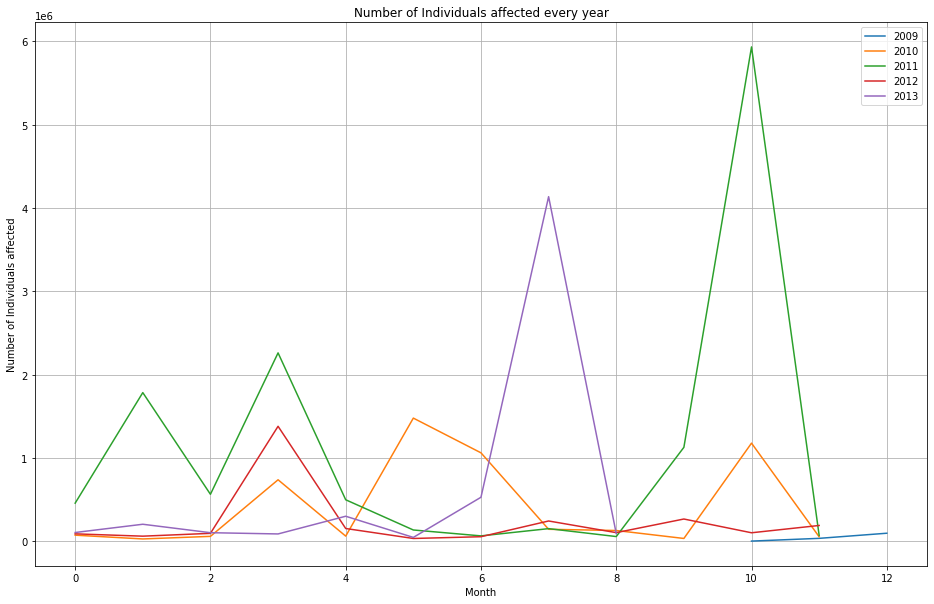

In [ ]:
plotyearly(df1)

In [ ]:
str = "The the architecture was WAS stunning."

In [ ]:
"".join(str).split()

['The', 'the', 'architecture', 'was', 'WAS', 'stunning.']

In [ ]:
str.split()

['The', 'the', 'architecture', 'was', 'WAS', 'stunning.']

In [ ]:
from collections import Counter
Counter(str.split()).most_common(100)

[('The', 1),
 ('the', 1),
 ('architecture', 1),
 ('was', 1),
 ('WAS', 1),
 ('stunning.', 1)]

In [ ]:
pd.Series(str.lower().split()).value_counts()

the             2
was             2
architecture    1
stunning.       1
dtype: int64